<a href="https://colab.research.google.com/github/ctrivino1/Deep-Learning-For-Hackers/blob/master/14.time-series-anomaly-detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Jan 16 18:03:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install gdown
!pip install tensorflow-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.5 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [4]:
!gdown --id 10vdMg_RazoIatwrT7azKFX4P02OebU76 --output spx.csv

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=10vdMg_RazoIatwrT7azKFX4P02OebU76
To: /content/spx.csv
100% 152k/152k [00:00<00:00, 91.9MB/s]


In [5]:
df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')

In [6]:
df.head()

,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


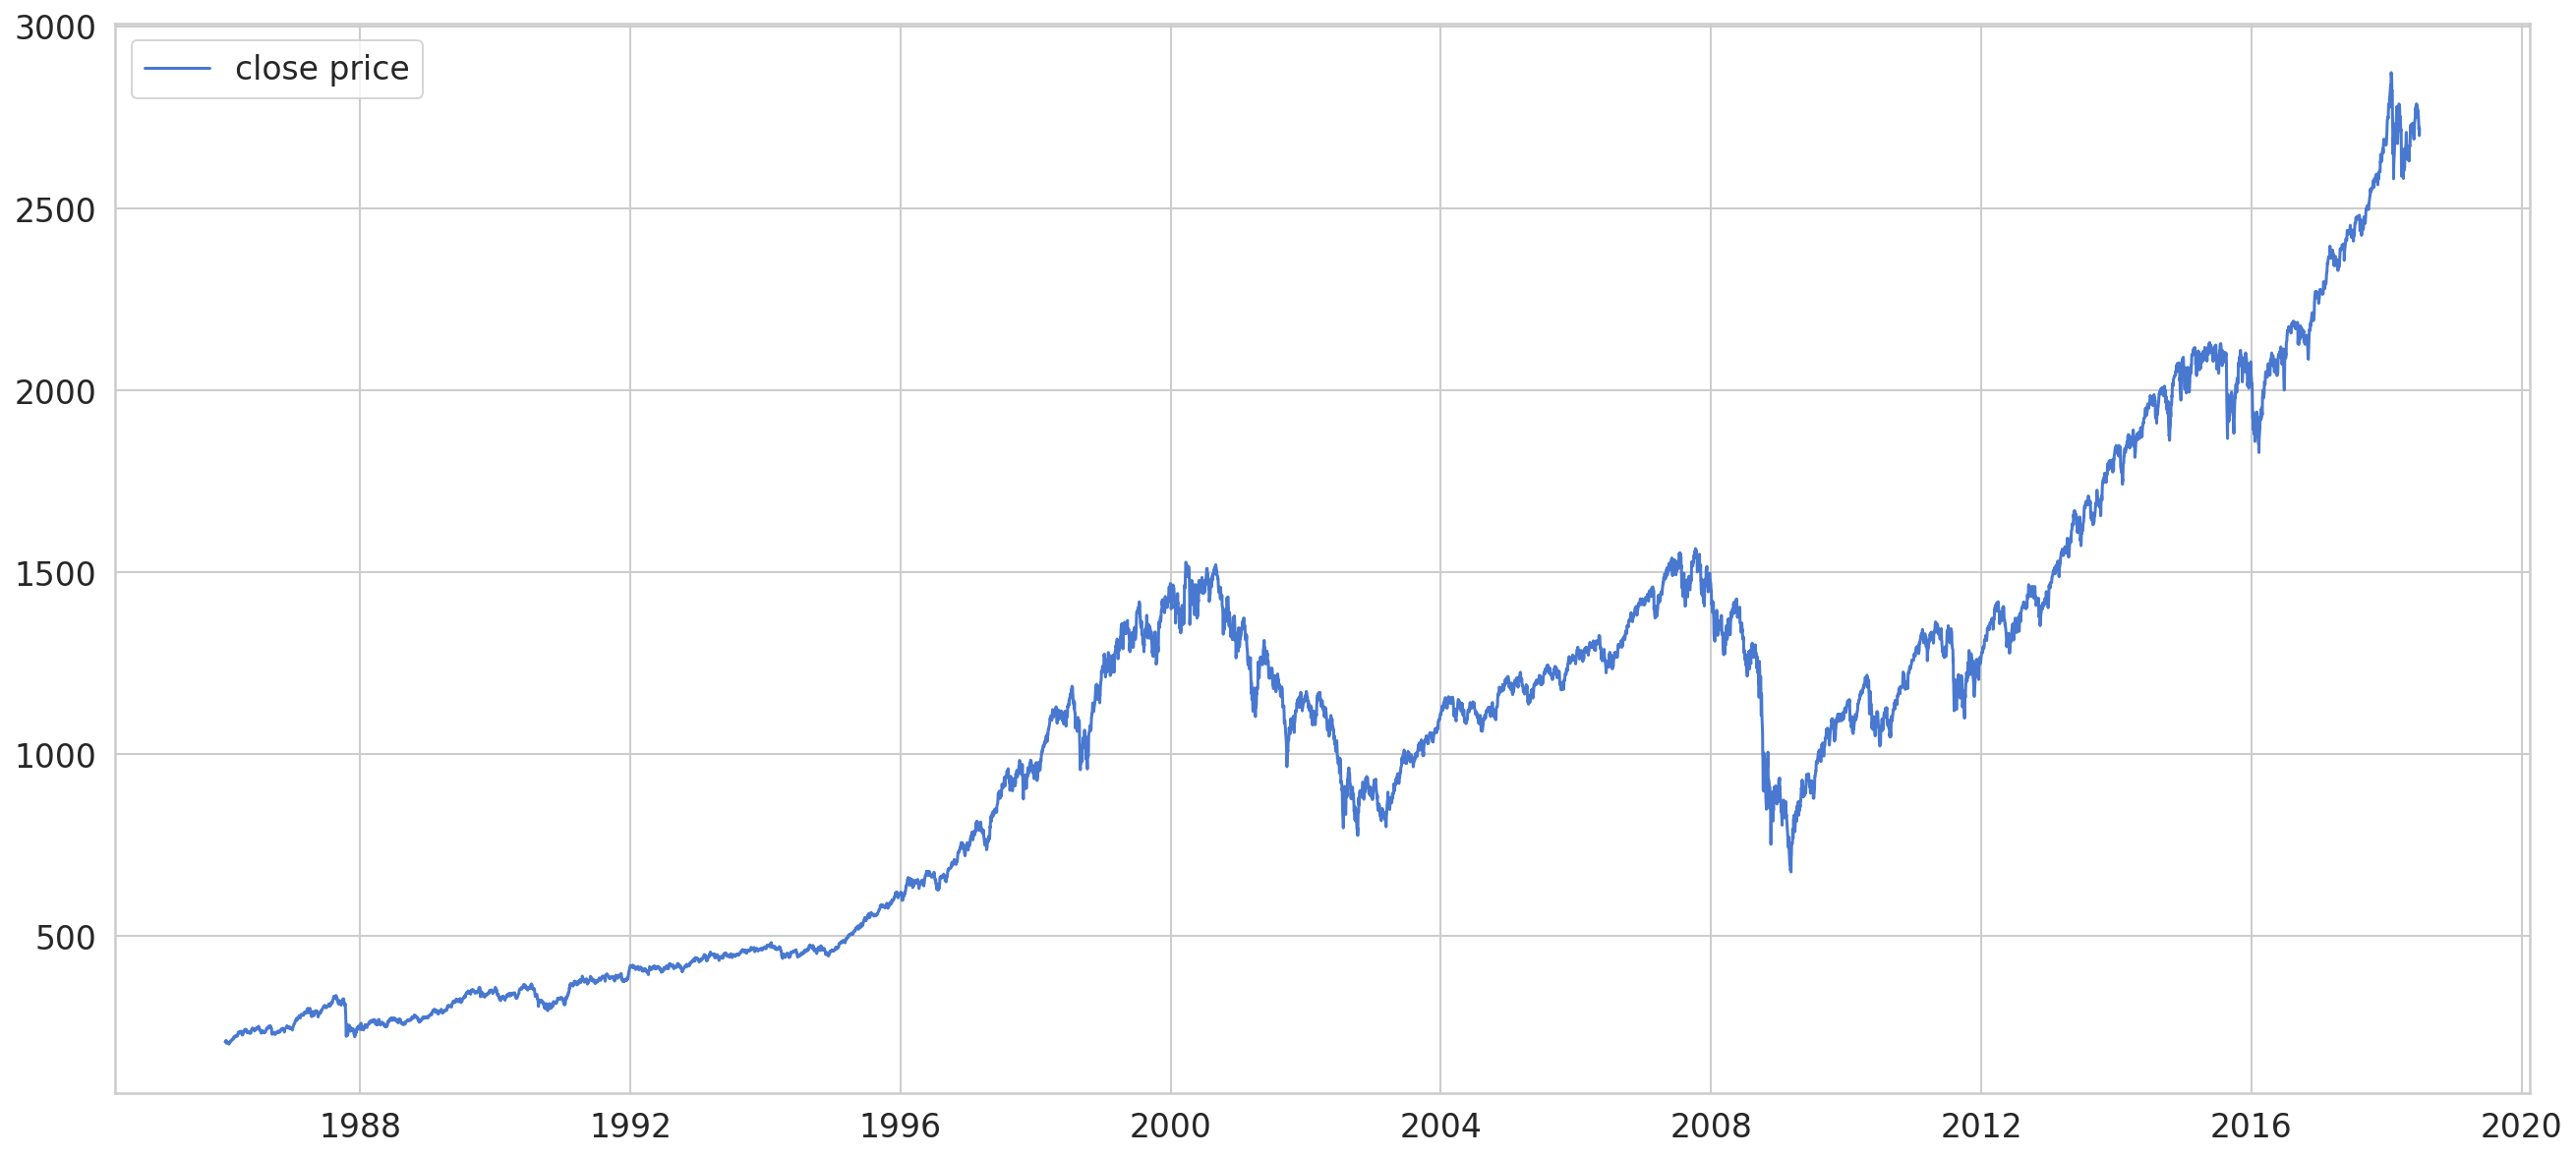

In [7]:
plt.plot(df, label='close price')
plt.legend();

In [8]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(7782, 1) (410, 1)


In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

<ipython-input-9-419ee0323bae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['close'] = scaler.transform(train[['close']])
<ipython-input-9-419ee0323bae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['close'] = scaler.transform(test[['close']])


In [10]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [22]:
train[['close']].head()

,close
date,
1986-01-02,-1.475126
1986-01-03,-1.472703
1986-01-06,-1.473135
1986-01-07,-1.467219
1986-01-08,-1.478169


In [24]:
train.close.head

<bound method NDFrame.head of date
1986-01-02   -1.475126
1986-01-03   -1.472703
1986-01-06   -1.473135
1986-01-07   -1.467219
1986-01-08   -1.478169
                ...   
2016-11-04    2.047774
2016-11-07    2.134814
2016-11-08    2.149916
2016-11-09    2.194431
2016-11-10    2.202357
Name: close, Length: 7782, dtype: float64>

In [11]:
TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['close']], train.close, TIME_STEPS)
X_test, y_test = create_dataset(test[['close']], test.close, TIME_STEPS)

print(X_train.shape)

(7752, 30, 1)


In [12]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

In [13]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
218/218 [==============================] - 16s 19ms/step - loss: 0.1782 - val_loss: 0.2954
Epoch 2/10
218/218 [==============================] - 2s 11ms/step - loss: 0.1034 - val_loss: 0.2063
Epoch 3/10
218/218 [==============================] - 1s 7ms/step - loss: 0.1037 - val_loss: 0.1628
Epoch 4/10
218/218 [==============================] - 1s 7ms/step - loss: 0.1301 - val_loss: 0.1991
Epoch 5/10
218/218 [==============================] - 2s 7ms/step - loss: 0.1325 - val_loss: 0.2774
Epoch 6/10
218/218 [==============================] - 1s 7ms/step - loss: 0.1147 - val_loss: 0.2943
Epoch 7/10
218/218 [==============================] - 1s 7ms/step - loss: 0.1149 - val_loss: 0.2728
Epoch 8/10
218/218 [==============================] - 1s 7ms/step - loss: 0.1239 - val_loss: 0.1561
Epoch 9/10
218/218 [==============================] - 1s 7ms/step - loss: 0.1106 - val_loss: 0.1485
Epoch 10/10
218/218 [==============================] - 2s 7ms/step - loss: 0.1233 - val_loss: 0.1

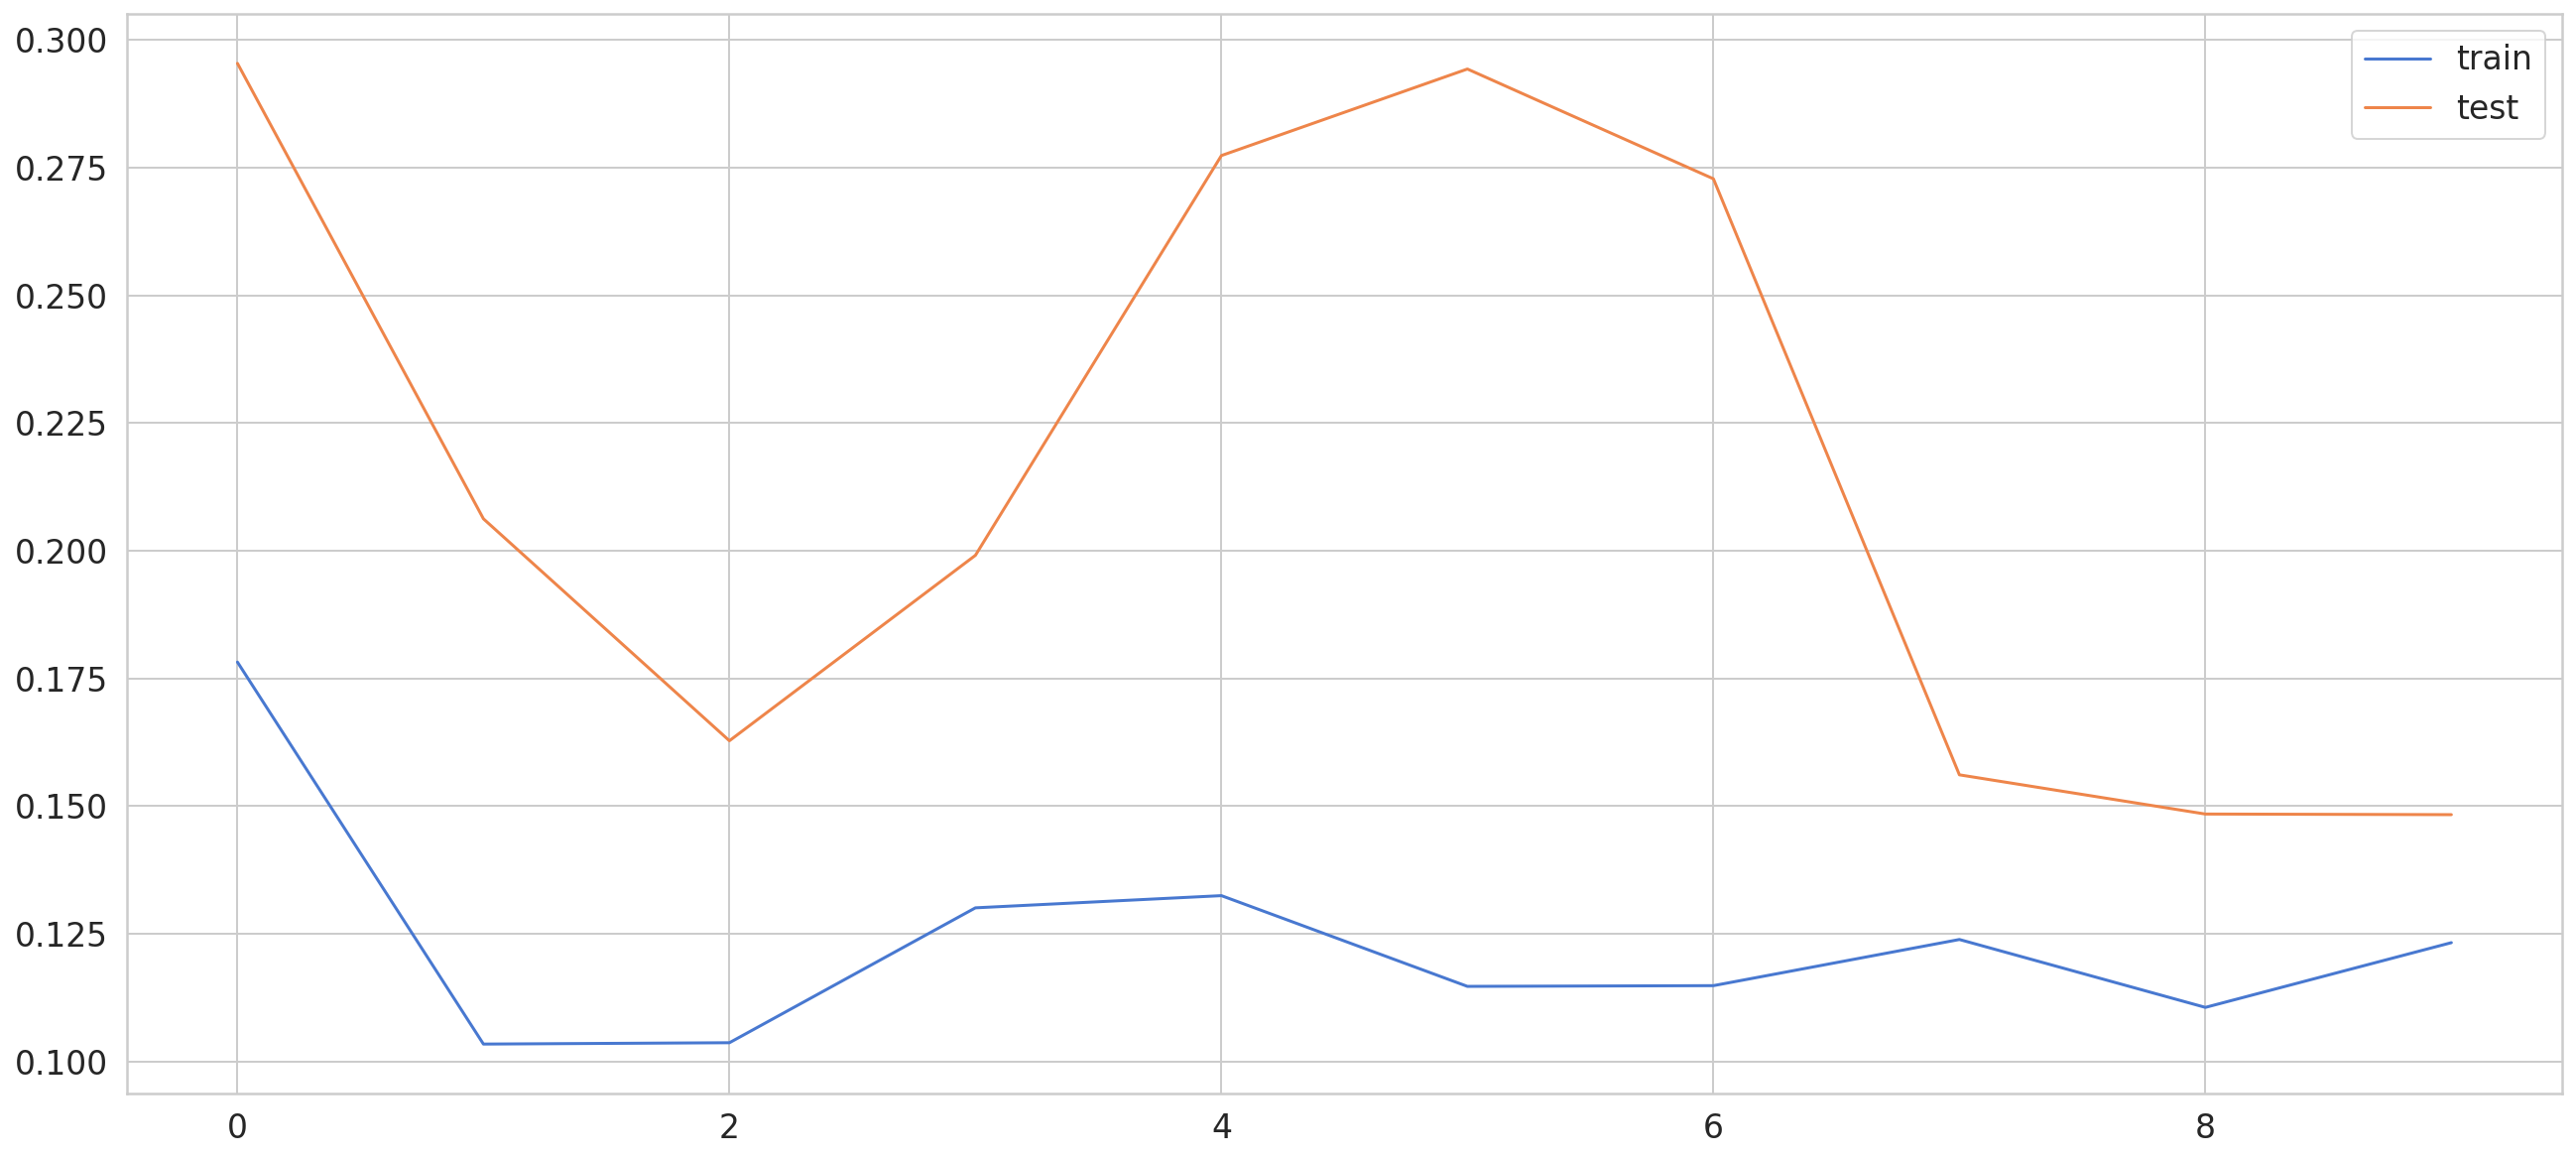

In [14]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [15]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

243/243 [==============================] - 1s 3ms/step


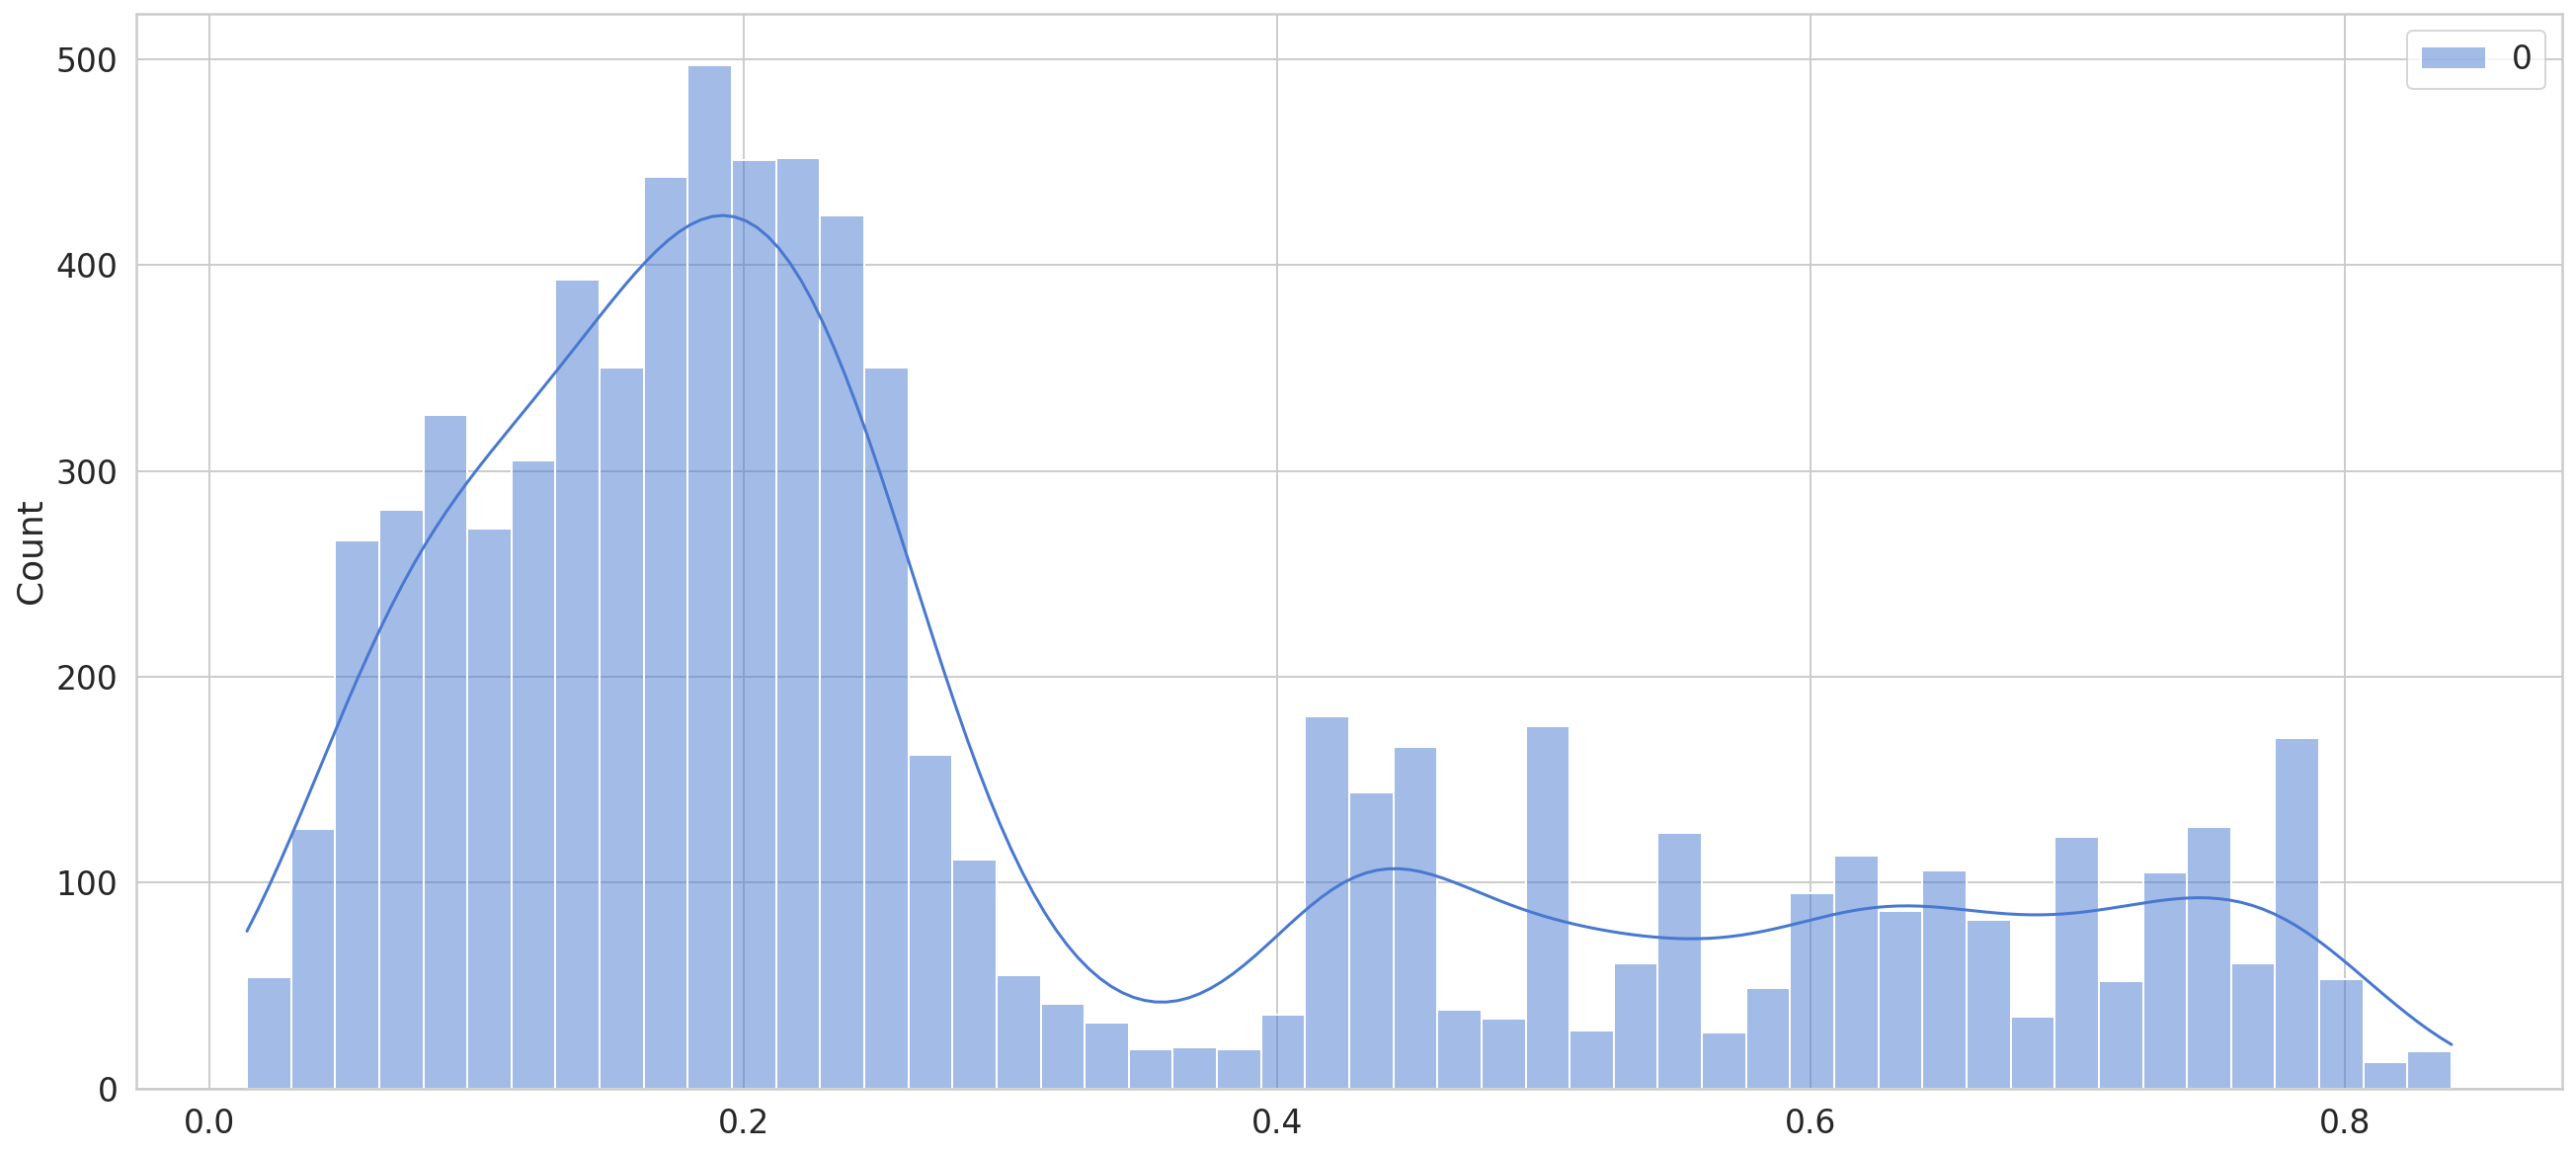

In [27]:
sns.histplot(train_mae_loss, bins=50, kde=True);

In [17]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

12/12 [==============================] - 0s 3ms/step


In [18]:
THRESHOLD = 0.65

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

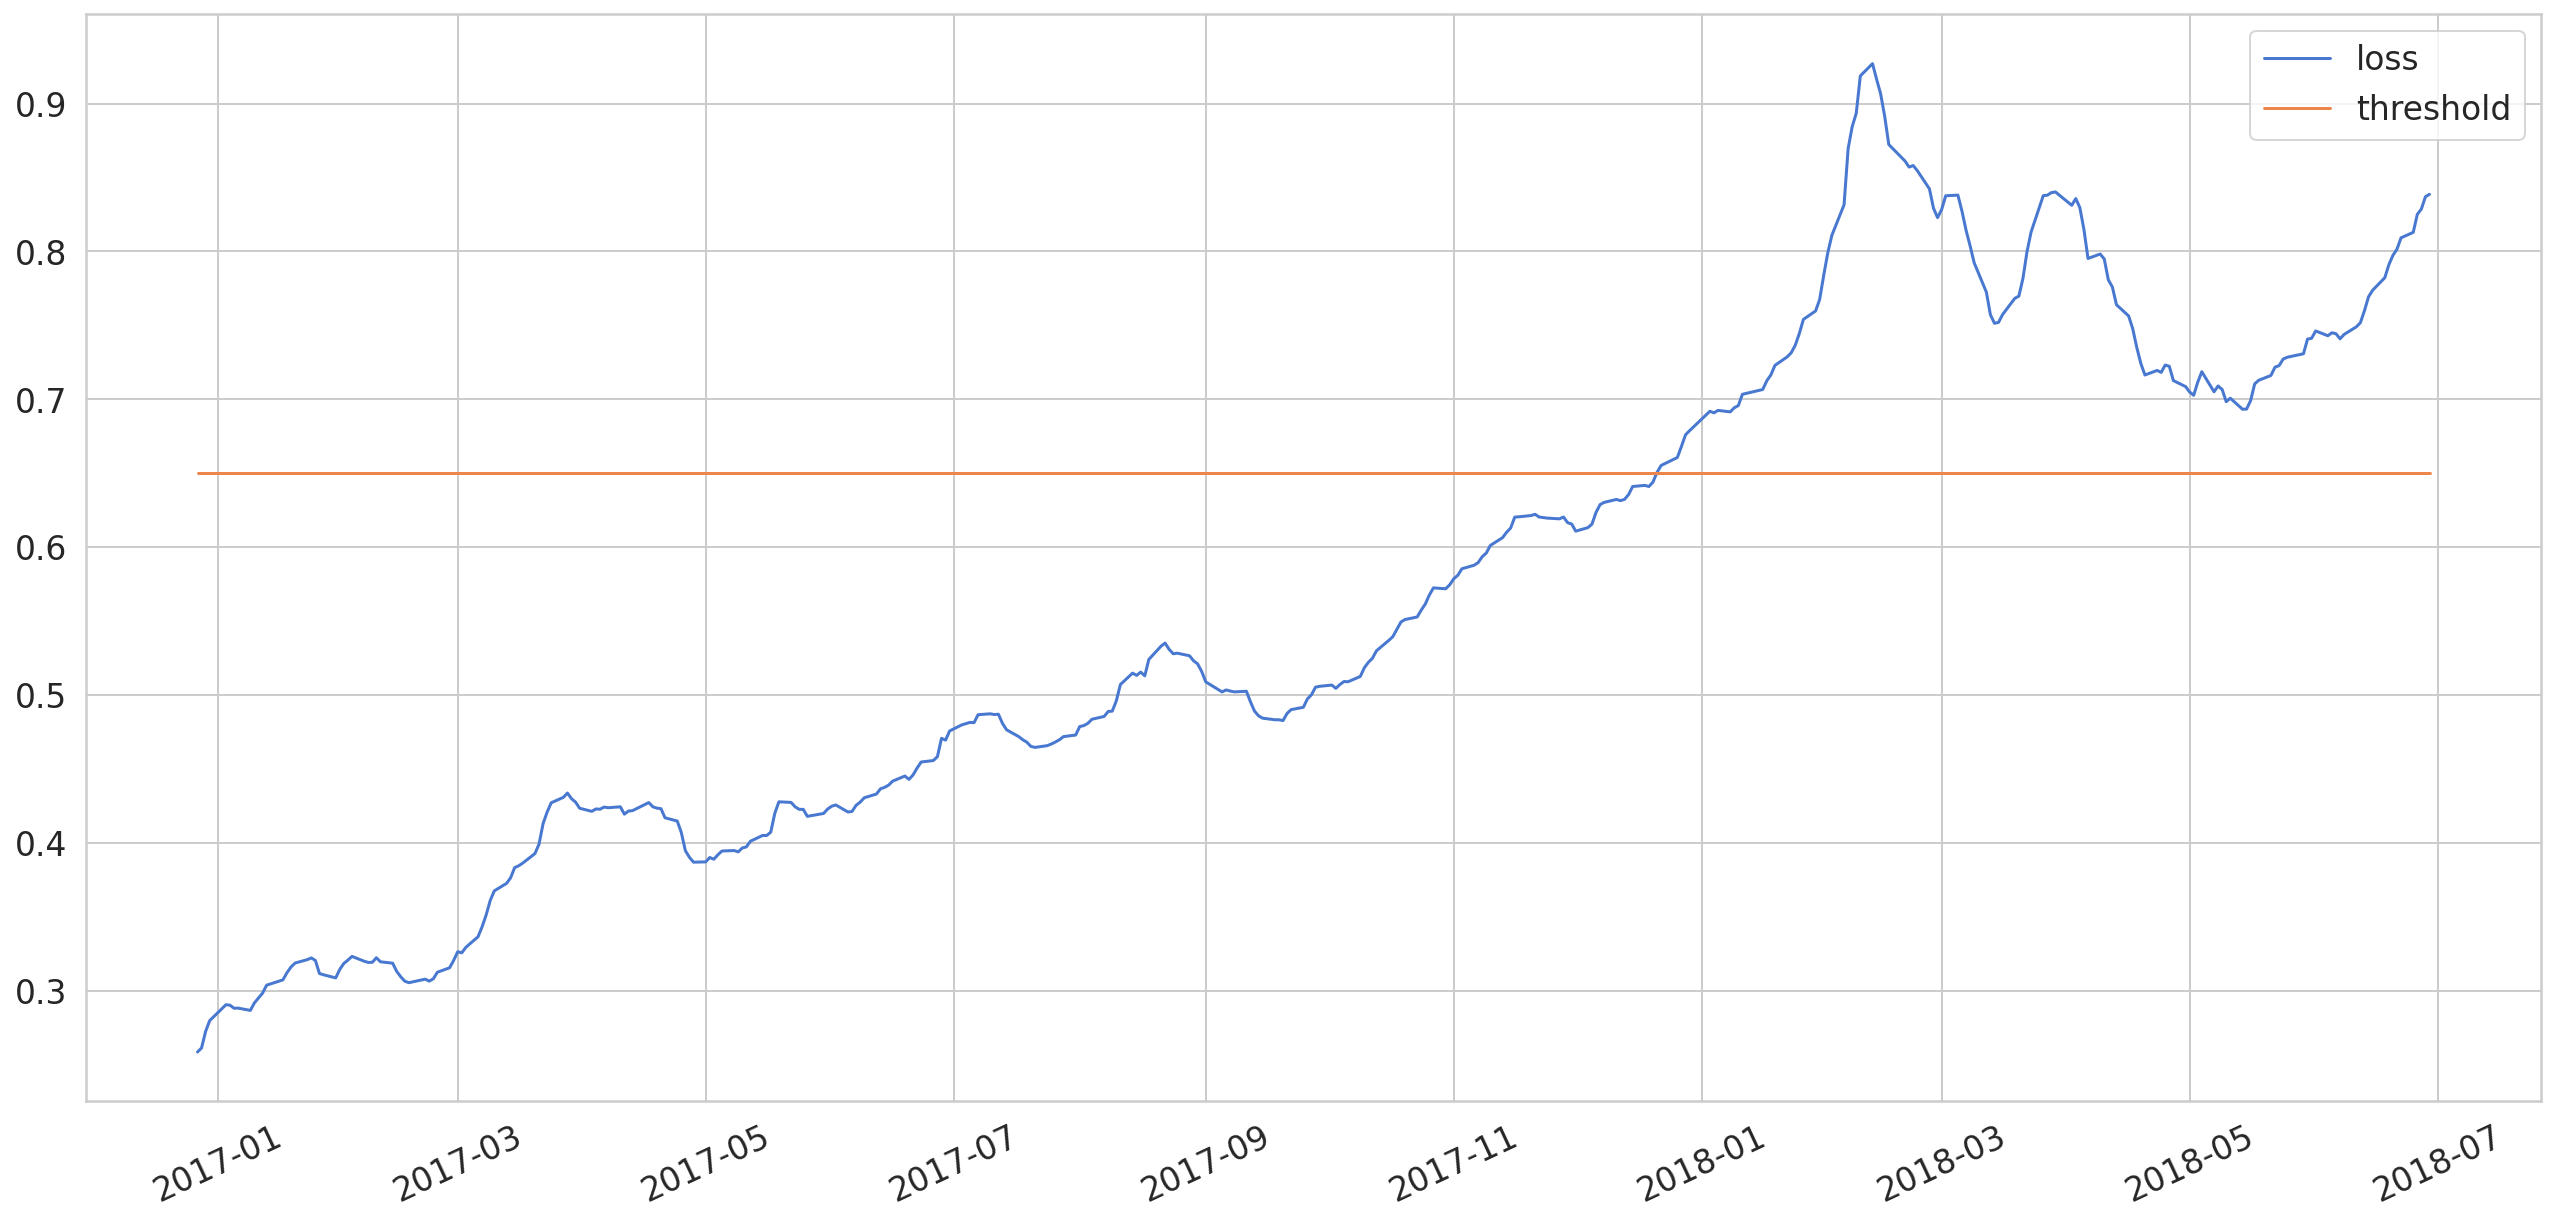

In [19]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [20]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,close
date,,,,
2017-12-21,0.650620,0.65,True,3.173602
2017-12-22,0.655273,0.65,True,3.171292
2017-12-26,0.660664,0.65,True,3.165957
2017-12-27,0.668150,0.65,True,3.169939
2017-12-28,0.675986,0.65,True,3.179181


In [ ]:
test[TIME_STEPS:].close.array.reshape(-1, 1)

In [107]:
test

,close
date,
2016-11-11,2.196666
2016-11-14,2.196197
2016-11-15,2.226606
2016-11-16,2.220126
2016-11-17,2.239247
...,...
2018-06-25,3.234646
2018-06-26,3.245897
2018-06-27,3.201889


In [108]:
anomalies.head()

,loss,threshold,anomaly,close
date,,,,
2017-12-21,0.650620,0.65,True,3.173602
2017-12-22,0.655273,0.65,True,3.171292
2017-12-26,0.660664,0.65,True,3.165957
2017-12-27,0.668150,0.65,True,3.169939
2017-12-28,0.675986,0.65,True,3.179181


In [111]:
scaler.inverse_transform(anomalies.close.array.reshape(-1, 1)).flatten()

array([2684.57, 2683.34, 2680.5 , 2682.62, 2687.54, 2673.61, 2695.81,
       2713.06, 2723.99, 2743.15, 2747.71, 2751.29, 2748.23, 2767.56,
       2786.24, 2776.42, 2802.56, 2798.03, 2810.3 , 2832.97, 2839.13,
       2837.54, 2839.25, 2872.87, 2853.53, 2822.43, 2823.81, 2821.98,
       2762.13, 2648.94, 2695.14, 2681.66, 2581.  , 2619.55, 2656.  ,
       2662.94, 2698.63, 2731.2 , 2732.22, 2716.26, 2701.33, 2703.96,
       2747.3 , 2779.6 , 2744.28, 2713.83, 2677.67, 2691.25, 2720.94,
       2728.12, 2726.8 , 2738.97, 2786.57, 2783.02, 2765.31, 2749.48,
       2747.33, 2752.01, 2712.92, 2716.94, 2711.93, 2643.69, 2588.26,
       2658.55, 2612.62, 2605.  , 2640.87, 2581.88, 2614.45, 2644.69,
       2662.84, 2604.47, 2613.16, 2656.87, 2642.19, 2663.99, 2656.3 ,
       2677.84, 2706.39, 2708.64, 2693.13, 2670.14, 2670.29, 2634.56,
       2639.4 , 2666.94, 2669.91, 2648.05, 2654.8 , 2635.67, 2629.73,
       2663.42, 2672.63, 2671.92, 2697.79, 2723.07, 2727.72, 2730.13,
       2711.45, 2722

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


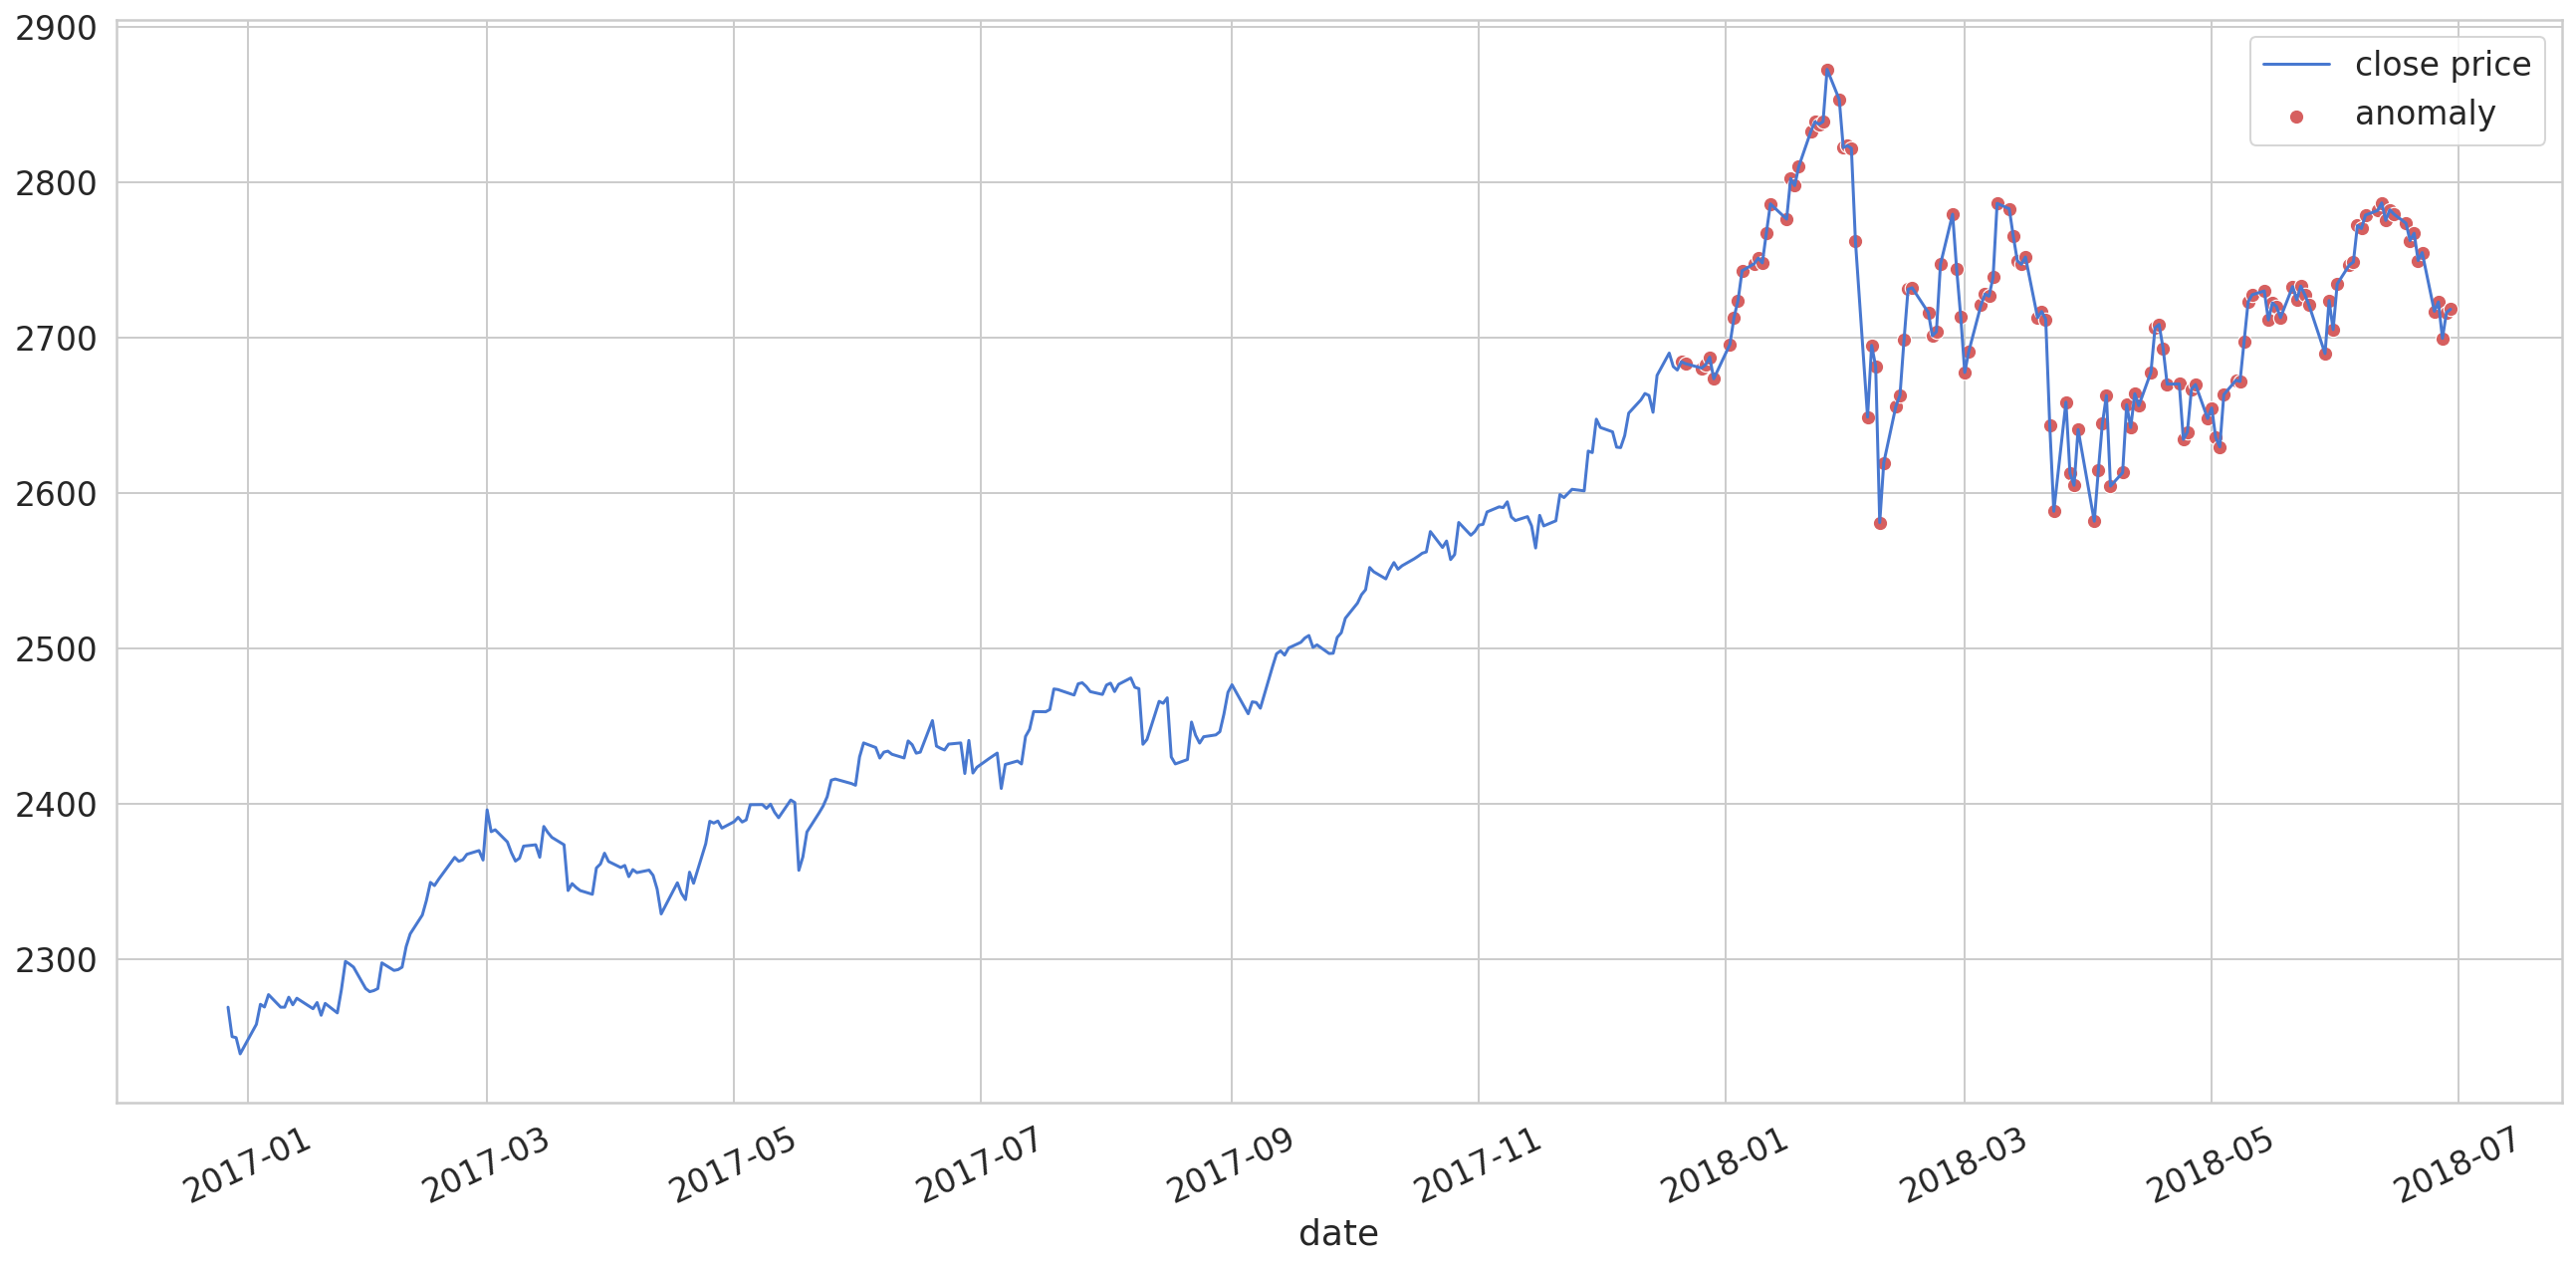

In [113]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].close.array.reshape(-1, 1)), 
  label='close price'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.close.array.reshape(-1, 1)).flatten(),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();